Reference : https://www.cse.wustl.edu/~garnett/cse515t/fall_2019/files/lecture_notes/8.pdf

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from laplace import Laplace
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset

C:\Users\Inder\AppData\Local\Temp\ipykernel_31552\1563854125.py:20: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(['Class 0'] , ['Class 1'])


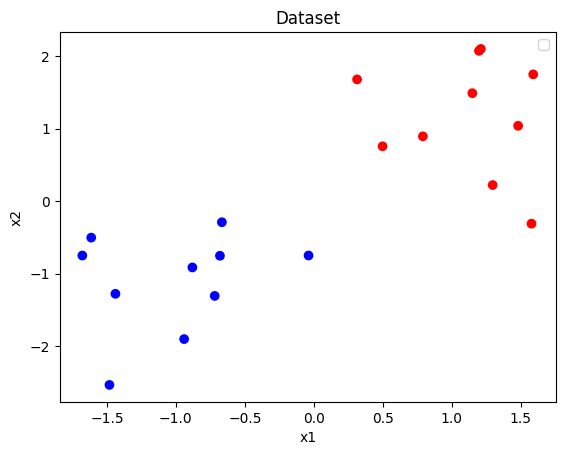

In [2]:
# Dataset
 
dist1 = torch.distributions.MultivariateNormal(torch.tensor([-1., -1.]), torch.eye(2)/4)
dist2 = torch.distributions.MultivariateNormal(torch.tensor([1., 1.]), torch.eye(2)/4)

#Sample 10 points from each distribution
x1 = dist1.sample((10,))
x2 = dist2.sample((10,))
X = torch.cat((x1, x2), 0)

#Create labels for each class
y1 = torch.zeros(10, dtype=torch.float32)
y2 = torch.ones(10, dtype=torch.float32)
Y = torch.cat((y1, y2), 0)

plt.title('Dataset')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr')
plt.legend(['Class 0'] , ['Class 1'])
plt.show()

In [3]:
X = X.reshape(20, 2)
Y = Y.reshape(20, 1)

In [4]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)

In [5]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            3
├─Sigmoid: 1-2                           --
Total params: 3
Trainable params: 3
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            3
├─Sigmoid: 1-2                           --
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [7]:
train_loader = DataLoader(
    TensorDataset(X, Y), 
    batch_size=1
)

In [9]:
la = Laplace(model, 'classification',
             subset_of_weights='all',
             hessian_structure='full')

la.fit(train_loader)

In [13]:
pred = la(X)

In [11]:
y_pred = model(X)
y_pred

tensor([[0.6987],
        [0.4553],
        [0.5467],
        [0.6254],
        [0.4773],
        [0.4217],
        [0.4050],
        [0.4691],
        [0.4892],
        [0.5331],
        [0.1906],
        [0.3615],
        [0.2737],
        [0.4373],
        [0.2152],
        [0.1650],
        [0.1630],
        [0.1952],
        [0.2648],
        [0.2861]], grad_fn=<SigmoidBackward0>)

In [8]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def prior_logprob(mean_prior, cov_prior , theta):
    dist = torch.distributions.MultivariateNormal(mean_prior, cov_prior)
    return dist.log_prob(theta)

def likelihood_logprob(X,Y,theta):
    logprob = torch.tensor(0. , requires_grad=True)
    probs = torch.sigmoid(torch.matmul(X, theta.T))
    for i in range(len(X)):
        logprob = logprob + torch.log(probs[i]) * Y[i] + torch.log(1 - probs[i]) * (1 - Y[i])
    return logprob

# Can do Shape manipulation better 
def unnormalized_posterior_logprob(mean_prior, cov_prior, X,Y,theta):
    return prior_logprob(mean_prior, cov_prior, theta) + likelihood_logprob(X,Y,theta)

In [9]:
theta_mle = torch.tensor([0., 0., 0.], requires_grad=True)
optimizer = torch.optim.Adam([theta_mle], lr=0.01)

for i in range(1000):
    loss = -likelihood_logprob(X,Y,theta_mle)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

C:\Users\Inder\AppData\Local\Temp\ipykernel_11916\1343946516.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  probs = torch.sigmoid(torch.matmul(X, theta.T))


In [10]:
theta_mle

tensor([-0.2637,  2.5417,  2.5717], requires_grad=True)

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


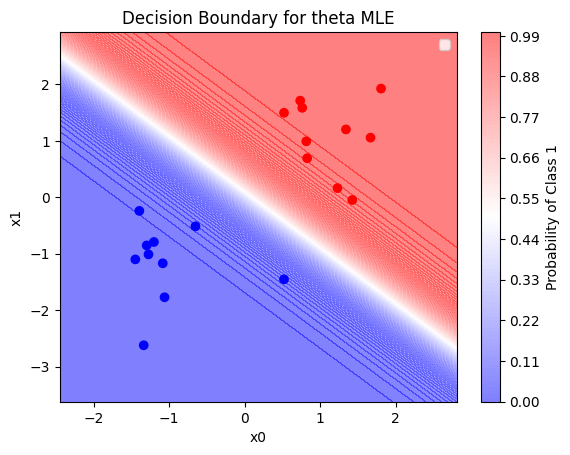

In [11]:
# Plot the decision boundary

min_x0 = torch.min(X[:, 1])
max_x0 = torch.max(X[:, 1])

min_x1 = torch.min(X[:, 2])
max_x1 = torch.max(X[:, 2])

x = torch.linspace(min_x0-1, max_x0+1, 100)
y = torch.linspace(min_x1-1, max_x1+1, 100)

X_mesh, Y_mesh = torch.meshgrid(x, y)
Z = torch.zeros(X_mesh.shape)
for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z[i, j] = torch.sigmoid(torch.dot(theta_mle, torch.tensor([1 , X_mesh[i, j], Y_mesh[i, j]]).T))

X_np = X_mesh.detach().numpy()
Y_np = Y_mesh.detach().numpy()
Z_np = Z.detach().numpy()

plt.contourf(X_np, Y_np, Z_np, cmap='bwr' , levels=100, alpha=0.5)
plt.title('Decision Boundary for theta MLE')
plt.xlabel('x0')
plt.ylabel('x1')
cbar = plt.colorbar()
cbar.set_label('Probability of Class 1')    
plt.legend()
plt.scatter(X[:, 1], X[:, 2], c=Y, cmap='bwr')
plt.show()

In [12]:
mean_prior = torch.tensor([0., 0.,0.])
cov_prior = torch.eye(3)

theta = torch.tensor([0., 0., 0.], requires_grad=True)

In [13]:
optimizer = torch.optim.Adam([theta], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()
    loss = -unnormalized_posterior_logprob(mean_prior, cov_prior,X,Y, theta)
    loss.backward(retain_graph=True)
    optimizer.step()

theta_map = theta

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


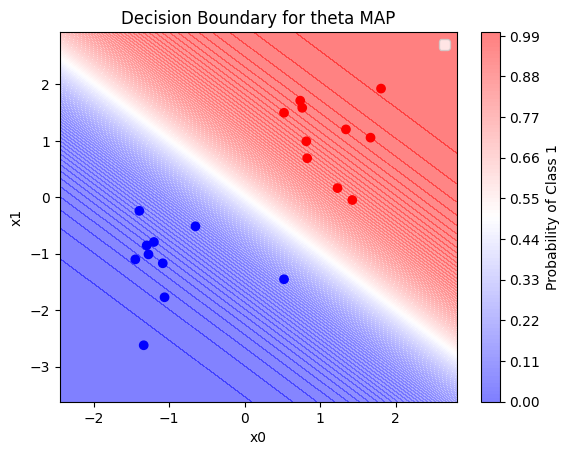

In [14]:
# Plot the decision boundary

min_x0 = torch.min(X[:, 1])
max_x0 = torch.max(X[:, 1])

min_x1 = torch.min(X[:, 2])
max_x1 = torch.max(X[:, 2])

x = torch.linspace(min_x0-1, max_x0+1, 100)
y = torch.linspace(min_x1-1, max_x1+1, 100)

X_mesh, Y_mesh = torch.meshgrid(x, y)
Z = torch.zeros(X_mesh.shape)
for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z[i, j] = torch.sigmoid(torch.dot(theta_map, torch.tensor([1 , X_mesh[i, j], Y_mesh[i, j]]).T))

X_np = X_mesh.detach().numpy()
Y_np = Y_mesh.detach().numpy()
Z_np = Z.detach().numpy()

plt.contourf(X_np, Y_np, Z_np, cmap='bwr' , levels=100, alpha=0.5)
plt.title('Decision Boundary for theta MAP')
plt.xlabel('x0')
plt.ylabel('x1')
cbar = plt.colorbar()
cbar.set_label('Probability of Class 1')    
plt.legend()
plt.scatter(X[:, 1], X[:, 2], c=Y, cmap='bwr')
plt.show()